# PHYLOGENETIC TREES WITH DIGITAL ANNEALER

The main objective of this method is to consecutively divide a set of nodes or species with Fujitsu's Digital Annealer until a phylogenetic tree is obtained.

In [1]:
from dadk.QUBOSolverCPU import *
from dadk.Solution_SolutionList import *
from dadk.BinPol import *

import networkx as nx
from openpyxl import load_workbook
import csv
import numpy as np

## Data collecting

In order to be able to obtain a phylogenetic tree, we need a set of species and a measurement that allows us to determine how close they are to each other. This would constitute the nodes and the edges of the graph we are going to cut. 

For that, we have originally taken datasets from [Phylome DB](https://phylomedb.org/phylomes?s=expl), a database webpage of different phylomes that offers both the standard accepted phylogenetic tree and the amino acid sequences of the species. With this amino acid sequence, in FASTA format, we have used the $\verb|func_cleanfasta|$ to clean up the .fasta files and fed it to BLAST+. The program analyzes its database of aminoacid sequences and following a local comparison algorithm, returns several metrics, among which we find the bit scores. 

Bit scores are a good metric that take several characteristics into account to determine how closely related the two species are. They are not normalized when they first come out of BLAST+, so the first step to get a proper matrix of similarities is to normalize them. Let us see how we do that with the following code.

In [23]:
# IMPORT SIMILARITY MATRIX (EXCEL FILE)

def import_from_excel(filename):

    # Open up the Excel file
    workbook = load_workbook(filename)
    
    # Get the first sheet
    worksheet = workbook.worksheets[0]
    
    column_list = []
    
    # Obtain a list of lists (each element is a column of the file)
    for c in worksheet.columns:
        row = [cell.value for cell in c]
        column_list.append(row)
    
    # Clean up header and select nodes_query column, nodes_sub column and bit_score column
    nodes_query = column_list[0][1:]
    nodes_sub = column_list[1][1:]
    bit_scores = column_list[11][1:]
    
    bit_scores = [float(i) for i in bit_scores]

    nodes = extract_nodes(nodes_query, nodes_sub)
    bitscore_matrix = extract_matrix(nodes_query, nodes_sub, nodes, bit_scores)

    return(nodes, bitscore_matrix)

In [24]:
# IMPORT SIMILARITY MATRIX (TSV FILE)

def import_from_tsv(filename):

    tsv_path = filename
    column_list = []
    
    # Reads all rows as lists first
    
    with open(tsv_path, newline='', encoding='utf-8') as f:
        reader = csv.reader(f, delimiter='\t')
        rows = list(reader)
    
    # Transpose rows for columns
    
    for col in zip(*rows):
        column_list.append(list(col))
    
    # No header
    
    nodes_query = column_list[0]
    nodes_sub = column_list[1]
    bit_scores = column_list[11]
    
    bit_scores = [float(i) for i in bit_scores]

    nodes = extract_nodes(nodes_query, nodes_sub)
    bitscore_matrix = extract_matrix(nodes_query, nodes_sub, nodes, bit_scores)

    return(nodes, bitscore_matrix)

The reason for $\verb|nodes_query|$ and $\verb|nodes_sub|$ to exist is that BLAST+ first creates a database with our .fasta file and calls the species in that database 'Subject'. Then it iteratively compares the sequences in the original .fasta ('Queries') with the ones on the database, so we have two columns with all the possible pairs in the set. To have a proper array with only the nodes (sequences) for future use, we will search through the first column and get the unique names out of it.

In [25]:
def extract_nodes(nodes_query, nodes_sub):

    nodes = []
    current_node_name = nodes_query[0]
    nodes.append(current_node_name)
    
    for i in range(len(nodes_query)):
        if nodes_query[i] != current_node_name:
            nodes.append(nodes_query[i])
            current_node_name = nodes_query[i]
    
    return(nodes)

Now, we will normalize the bit scores. We will use the formula

$$ Norm_{bit(i,j)} = \frac{bit(i,j)}{\mathrm{mean}\{bit(i,i), bit(j,j)\}}*100. $$



We must also rearrange the $\verb|bit_scores_norm|$ array into a matrix. This is not a trivial step, as the total length of the array is not exactly $nodes \times nodes $, since some species are so distantly related that BLAST+ has purged them out. For those cases, we will asign the default zero to the edge between those nodes.

In [26]:
def extract_matrix(nodes_query, nodes_sub, nodes, bit_scores):

    n_total = len(bit_scores)
    
    bit_scores_norm = []
    
    # We iterate over the entire array of bit scores
    
    for k in range(n_total):
    
        # We save the name of the query and subject
        query_name = nodes_query[k]
        sub_name = nodes_sub[k]
    
        # We iterate over the rest of the list finding the bit(query,query) = bit(i,i)
        # and bit(subject,subject) = bit(j,j)
    
        for i in range(n_total):
            
            if nodes_query[i] == query_name and nodes_sub[i] == query_name:
                bit_i_i = bit_scores[i]
    
            if nodes_query[i] == sub_name and nodes_sub[i] == sub_name:
                bit_j_j = bit_scores[i]
    
        # Calculate the mean
        mean_scores = (bit_i_i + bit_j_j)/2
    
        # Apply formula
        bit_scores_norm.append(bit_scores[k]*100/mean_scores)
        

    ### BIT SCORE MATRIX BUILD ###
    
    bitscore_matrix = np.zeros([len(nodes),len(nodes)])
    
    for k in range(n_total):
    
        # for each element in bit_scores_norm, we search for the corresponding
        # indexes (matching names) in the nodes array, thus we find the
        # corresponding column and row in the matrix
        
        index_query = nodes.index(nodes_query[k])
        index_sub = nodes.index(nodes_sub[k])
        bitscore_matrix[index_query,index_sub] = bit_scores_norm[k]


    ### TRIANGULATION ###
    
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            
            if bitscore_matrix[i][j] != bitscore_matrix[j][i]:
                mean_score = (bitscore_matrix[i][j] + bitscore_matrix[j][i])/2
                bitscore_matrix[i][j] = mean_score
                bitscore_matrix[j][i] = mean_score
    
            # Diag zeros
    
            if i == j:
                bitscore_matrix[i][j]=0

    return(bitscore_matrix)       

We find an interesting result when printing this matrix, which is that it is not exactly symmetrical. This is due to the algorithm that BLAST+ uses to compare queries against subjects. For example, if the amino acid sequence of a certain species is too short, it may yield different results when comparing that species with another as subject-query VS query-subject. In order to fix this, we have decided to triangulate the matrix by taking the mean between the corresponding entries $\mathrm{mean}(\verb|bitscore_matrix[i][j]|, \verb|bitscore_matrix[j][i]|)$.

## Modularity

In [27]:
# Simple function to hide the output of the QUBO solver

def _hide_pol_info(pol):
        pol.user_data['hide_scaling_info'] = True
        pol.user_data['hide_sampling_info'] = True
        return pol

In this subsection, we tried changing the post-processing expression to the modularity of two communities, another approach for clustering that measures how similar the elements of a community are among them and how dissimilar they are to the ones in another community. The specific method used was the implemented modularity function in the networkx package \verb|networkx.community.modularity|. For more information, please refer to notebook notebook \verb|func_Modularity|.

In [28]:
def QUBO(nodes, bitscore_matrix, c, alpha):
    
    ### FIRST POLYNOM: MinCut ###
    
    H_d = BinPol()
    for i in range(len(nodes)-1):
        for j in range(i+1, len(nodes)):
            H_ij = BinPol()
            H_ij.add_term(1, ('x',i))
            H_ij.add_term(-1, ('x',j))
            H_ij.power(2)
            bit_coef = bitscore_matrix[i][j].item() # change to float (DA doesnt like numpy.float) 
            H_ij = bit_coef*H_ij
            H_d.add(H_ij)
    
    ### SECOND POLYNOM: penalization ###
    
    H_alpha_aux = BinPol()
    for i in range(len(nodes)):
        H_alpha_aux.add_term(1, ('x',i))
    H_alpha = alpha*((H_alpha_aux-c).power(2))
    
    ### Total QUBO ###
    
    H_qubo = H_d + H_alpha
    H_qubo = _hide_pol_info(H_qubo)

    return(H_qubo)

In [29]:
### QUBO FUNCTION ITERATING C ###

def modularity_func(nodes, bitscore_matrix):

    # We choose alpha high enough that the DA respects the
    # value of c chosen.
    
    alpha = 10000

    # We define the varshape of our polynoms and fix it for the
    # entire process until the next division of nodes

    my_constant_bits = np.full((len(nodes),), -1, np.int8) 
    my_varshapeset = VarShapeSet(BitArrayShape(name='x', shape=(len(nodes),), axis_names = ['nodes'], constant_bits = my_constant_bits))
    BinPol.freeze_var_shape_set(my_varshapeset)

    # Options for the Solver
    
    solver = QUBOSolverCPU(
        number_iterations = 200000,
        number_runs = 10,
        scaling_bit_precision = 32,
        scaling_action = ScalingAction.AUTO_SCALING)

    # We initialize Modularity to a low enough value
    
    ref_modu = -10**50

    # Start of the loop, with c ranging from 1 to nodes/2
    
    for c in range(1, int(len(nodes)/2)+1):

        print('c=', c)
    
        H_qubo = QUBO(nodes, bitscore_matrix, c, alpha)
    
        ### SOLVER ###
        
        solution_list = solver.minimize(H_qubo)
        solution = solution_list.min_solution

        min_cut_array = solution.configuration

        print('min_cut_array=', min_cut_array)

        ### CHECK CONDITION ###

        counter = 0
        
        while sum(min_cut_array) != c:
            counter += 1
            alpha = alpha*10
            H_qubo = QUBO(nodes, bitscore_matrix, c, alpha)
            solution_list = solver.minimize(H_qubo)
            solution = solution_list.min_solution
            min_cut_array = solution.configuration

        alpha = alpha/(10**counter)
    
        ### MODULARITY ###
    
        edges_tuple = []

        for i in range(len(nodes)):
            for j in range(i+1, len(nodes)):
                edges_tuple.append((nodes[i], nodes[j], bitscore_matrix[i][j]))

        community1, community2 = assign_nodes(nodes, min_cut_array)
        print('communities \n', community1, community2)

        G = nx.Graph()
        G.add_weighted_edges_from(edges_tuple)
        current_modu = nx.community.modularity(G, [community1, community2], weight='weight', resolution=1)

        print('current_modularity=', current_modu)
        print('ref_modularity=', ref_modu)

        # We keep current_modu if it's higher than before (maximum)
    
        if current_modu > ref_modu:

            best_min_cut = solution.energy
            best_modu = current_modu
            best_modu_array = min_cut_array

            print('best_modularity=', best_modu)


            # Update old ref_modu with current value
            
            ref_modu = best_modu     

    return(best_min_cut, best_modu, best_modu_array)   

In [30]:
def assign_nodes(node_array, cut_array):

    # function that assigns the nodes to two new arrays
    # based on the solution array of the DA (cut_array)

    nodes_0 = []
    nodes_1 = []
    
    for i in range(len(cut_array)):
    
        if cut_array[i] == 0:
            nodes_0.append(node_array[i])
        elif cut_array[i] == 1:
            nodes_1.append(node_array[i])

    return(nodes_0, nodes_1)

In [31]:
def update_bit_matrix(old_bit_matrix, cut_array):

    # function that updates the bit score matrix
    # based on the solution array of the DA

    index_0 = []
    index_1 = []

    # loop that searches for the indexes of the columns and rows
    # associated to zero (respectively, one)

    for i in range(len(cut_array)):

        if cut_array[i] == 0:
            index_0.append(i)

        elif cut_array[i] == 1:
            index_1.append(i)

    # deletes rows and columns associated with one in bit score matrix
    # for nodes_0
 
    bitscore_matrix_0 = np.delete(old_bit_matrix, index_1, axis=0)
    bitscore_matrix_0 = np.delete(bitscore_matrix_0, index_1, axis=1)

    # same, deletes rows and columns associated with zero in bit score matrix
    # for nodes_1
    
    bitscore_matrix_1 = np.delete(old_bit_matrix, index_0, axis=0)
    bitscore_matrix_1 = np.delete(bitscore_matrix_1, index_0, axis=1)

    return(bitscore_matrix_0, bitscore_matrix_1)

In [32]:
def split_nodes(node_array, bitscore_matrix, key='0', result=None):

    if result is None:
        result = {}

    # Saves the current node array and its code in the result array

    result[key] = node_array

    # print('node_array=', node_array)

    # Stops if there is only one node left in the cluster (final leaf)

    if len(node_array)>1:

        # Calls the N_cut_func for the current array of nodes

        best_modu_array = modularity_func(node_array, bitscore_matrix)[2]

        # print('best_N_cut_array=', best_N_cut_array)

        # Divides the nodes based on the annealer array solution

        new_nodes = assign_nodes(node_array, best_modu_array)
        nodes_0 = new_nodes[0]
        nodes_1 = new_nodes[1]

        # print('nodes0=', nodes_0)
        # print('nodes1=', nodes_1)

        # Updates bit score matrix based on the annealers array solution
        # and matches with corresponding nodes array.

        bitscore_matrices = update_bit_matrix(bitscore_matrix, best_modu_array)

        bitscore_matrix_0 = bitscore_matrices[0]
        bitscore_matrix_1 = bitscore_matrices[1]

        # Recursevely calls itself to keep splitting the new nodes
        # Saves result in the result array above each time
                
        split_nodes(nodes_0, bitscore_matrix_0, key + '0', result)
        split_nodes(nodes_1, bitscore_matrix_1, key + '1', result)

    return(result)

-------------
-------------

## Phylogenetic tree reconstruction

Now that we have our final result array, let us reconstruct the tree with the binary code we have implemented. Later, we will use the BioPython package to visualize the results, once we have them in newick format.

In [33]:
from Bio import Phylo
import dendropy
from dendropy.calculate import treecompare
from itertools import combinations
from sklearn.metrics import mutual_info_score
from scipy.stats import entropy
from io import StringIO
import matplotlib.pyplot as plt
import re
import time

In [ ]:
# PACKAGES RELATED TO R

import os
os.environ['R_HOME'] = r'<path_to_R>\R\R-4.5.0'
from rpy2.robjects import r, globalenv
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
ape = importr('ape')
treedist = importr('TreeDist')

In [35]:
### IMPORT REAL TREE ###

def import_real_tree(filename):

    # Open up the Excel file
    workbook = load_workbook(filename)
    
    # Get the first sheet
    worksheet = workbook.worksheets[0]
    
    row_list = []
    
    for r in worksheet.rows:
        column = [cell.value for cell in r]
        row_list.append(column)
    
    return(row_list)

In [36]:
# FUNCTION THAT PRUNES INTERMEDIATE NODES FROM REAL TREE, IF ANY

def prune(tree):

    # substitutes string of the shape ...)NAME_OF_NODE_0001:0.1...
    # for ...):0.1... (standard format with only leave names)

    tree_nodes = re.sub(r'\)\s*[A-Za-z0-9\._]+:', '):', tree)
    tree_root = re.sub(r'\)\s*[A-Za-z0-9\._]+;', ');', tree_nodes)

    return(tree_root)

In [37]:
# FUNCTION THAT TRANSFORMS THE RECONSTRUCTED TREE DICTIONARY INTO NEWICK FORMAT

def dict_to_newick(tree_dict, branch_length=1.0):

    # function to reconstruct phylogenetic tree based on binary code
    # in the result dictionary

    def insert_path(tree, path, name):
        for direction in path[:-1]:
            if direction not in tree:
                tree[direction] = {}
            tree = tree[direction]
        tree[path[-1]] = name

    def build_newick(subtree):
        if isinstance(subtree, str):
            return f'{subtree}:{branch_length}'
        children = [build_newick(child) for child in subtree.values()]
        return f'({','.join(children)}):{branch_length}'

    root = {}
    for path, species_list in tree_dict.items():
        for species in species_list:
            insert_path(root, path, species)

    return build_newick(root) + ';'

### Percentage of correctly reconstructed tree

In order to measure the percentage of similarity between the real tree and the reconstructed one, we use the unweighted Robinson-Fould distance and the formula

$$ percentage_{correct} = \frac{Robinson-Foulds \ distance}{2N-6}*100, $$

where $N$ denotes the total number of external tips and $2N-6$ represents the maximal possible distance two trees can take. Therefore, this formula measures how many branches are recovered in the reconstructed tree compared with the true tree.

In [38]:
def percentage_rf(tree_real, tree_reconstructed, len_nodes):

    # shared_data creates a shared taxon space of node names for the two trees to use

    shared_taxa = dendropy.TaxonNamespace()

    # read trees in newick format into the dendropy syntax

    tree1 = dendropy.Tree.get(data = tree_real, schema="newick", taxon_namespace = shared_taxa)
    tree2 = dendropy.Tree.get(data = tree_reconstructed, schema="newick", taxon_namespace = shared_taxa)

    # calculate robinson-foulds distance

    robinson_foulds_distance = treecompare.symmetric_difference(tree1, tree2)

    # implement percentage formula

    percentage = 100 - robinson_foulds_distance*100/(2*len_nodes-6)

    return(percentage)

In [39]:
def percentage_cd(tree_real, tree_reconstructed):

    tree1 = ape.read_tree(text=tree_real)
    tree2 = ape.read_tree(text=tree_reconstructed)

    dist_r = treedist.ClusteringInfoDistance(tree1, tree2, normalize=True)
    
    distance = float(dist_r[0])
    
    return((1-distance)*100)

In [40]:
def visualize(tree, file_save):

    # function to visualize the phylogenetic trees using matplotlib

    # read tree in newick format into Phylo syntax

    handle_tree = StringIO(tree)
    tree = Phylo.read(handle_tree, 'newick')

    # build plot and save output

    fig = plt.figure(figsize=(20,18))
    axes = fig.add_subplot(1,1,1)
    Phylo.draw(tree, do_show=False, axes=axes)
    plt.savefig(file_save +'.jpg', dpi=300)
    plt.show()

## EXECUTION

In [ ]:
# specify directory of .tsv files

directory_of_tsv = r'<path_to_tsv_files>'

# specify directory of output txt and jpg

directory_output = r'<path_to_output_folder>'

# specify excel file of real trees in newick format

file_real_trees = r'<path_to_excel_file>\file.xlsx'

c= 1
min_cut_array= [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
communities 
 ['Phy000140T_ARATH', 'Phy000140U_ARATH', 'Phy0001A4D_ARATH', 'Phy0001E18_ARATH', 'Phy0001GUU_ARATH', 'Phy0001LKW_ARATH', 'Phy0001MUV_ARATH', 'Phy0001U9K_BOVIN', 'Phy0001VKN_BOVIN', 'Phy0002IUB_CANAL', 'Phy0003C91_CAEEL', 'Phy0004B2H_CIOIN', 'Phy0004U4K_CHLRE', 'Phy0005CPU_DICDI', 'Phy0005T0X_DROME', 'Phy00068CT_DANRE', 'Phy0006DXC_DANRE', 'Phy0007IH0_CHICK', 'Phy0007ZI4_HUMAN', 'Phy00081MK_HUMAN', 'Phy00084CT_HUMAN', 'Phy00084PF_HUMAN', 'Phy0008H3Y_HUMAN', 'Phy0009OAN_MOUSE', 'Phy0009YF3_MOUSE', 'Phy0009ZYG_MO

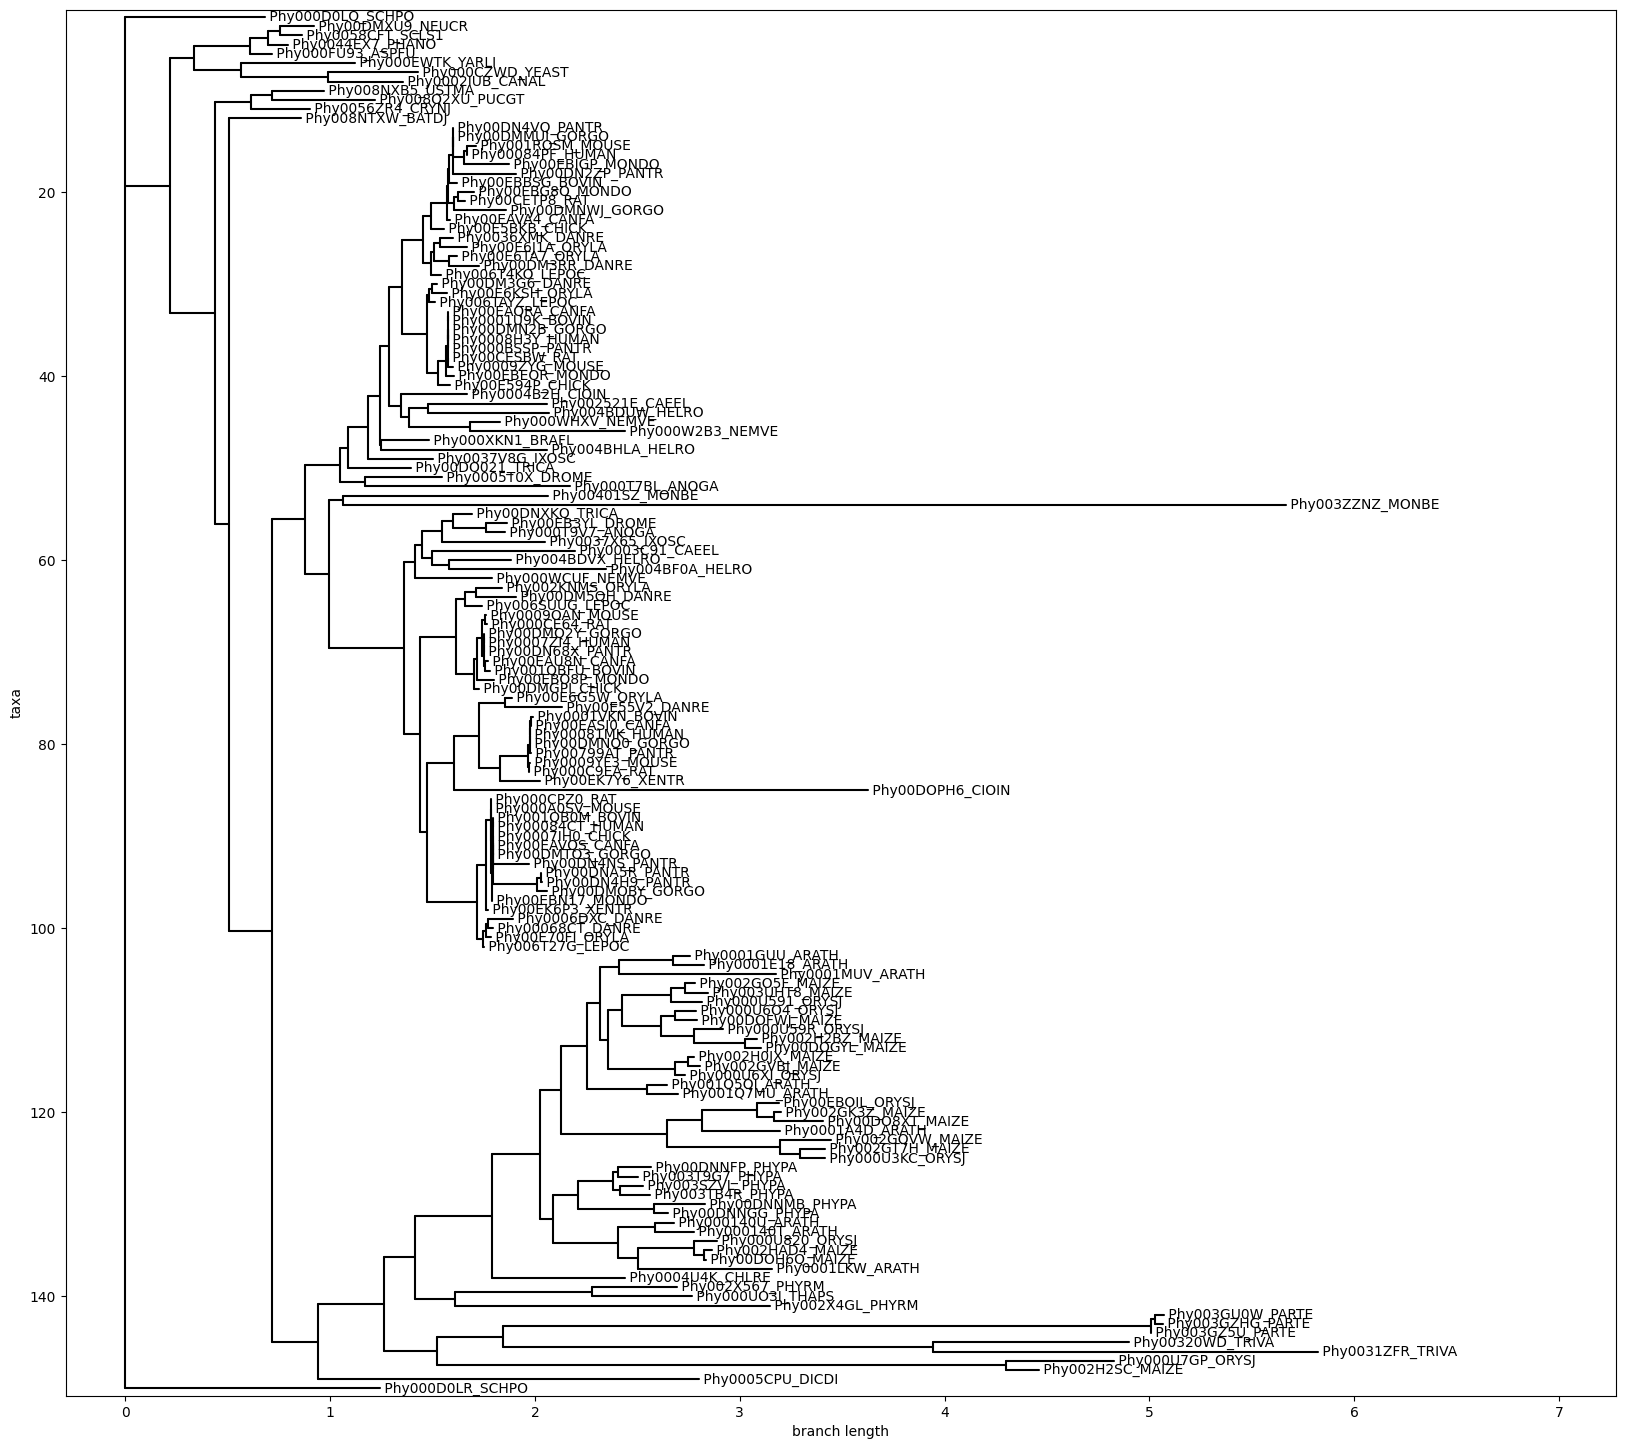

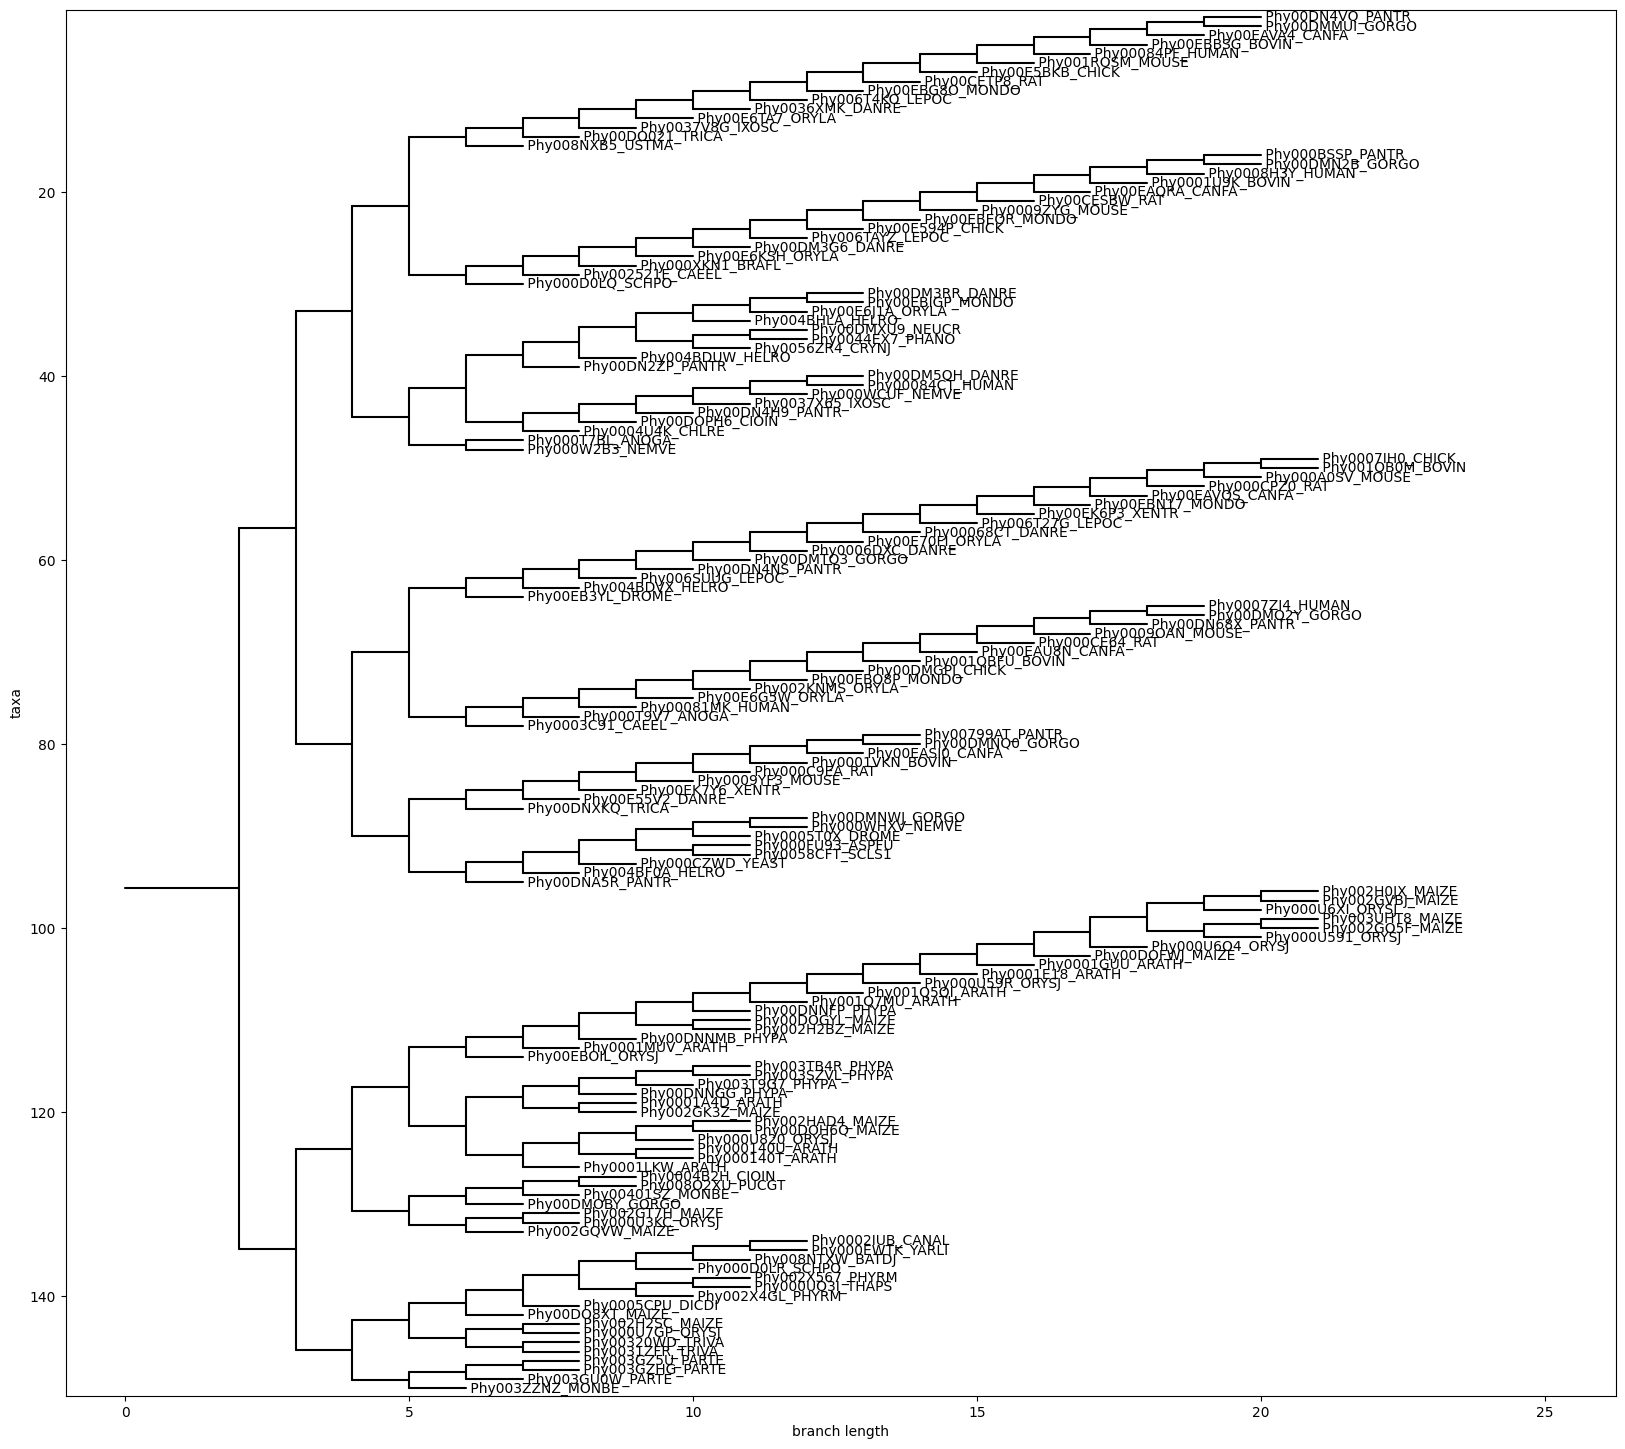

c= 1
min_cut_array= [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
communities 
 ['Phy000140T_ARATH', 'Phy000140U_ARATH', 'Phy0001A4D_ARATH', 'Phy0001E18_ARATH', 'Phy0001GUU_ARATH', 'Phy0001LKW_ARATH', 'Phy0001MUV_ARATH', 'Phy0001U9K_BOVIN', 'Phy0001VKN_BOVIN', 'Phy0002IUB_CANAL', 'Phy0003C91_CAEEL', 'Phy0004B2H_CIOIN', 'Phy0004U4K_CHLRE', 'Phy0005CPU_DICDI', 'Phy0005T0X_DROME', 'Phy00068CT_DANRE', 'Phy0006DXC_DANRE', 'Phy0007IH0_CHICK', 'Phy0007ZI4_HUMAN', 'Phy00081MK_HUMAN', 'Phy00084CT_HUMAN', 'Phy00084PF_HUMAN', 'Phy0008H3Y_HUMAN', 'Phy0009OAN_MOUSE', 'Phy0009YF3_MOUSE', 'Phy0009ZYG_MO

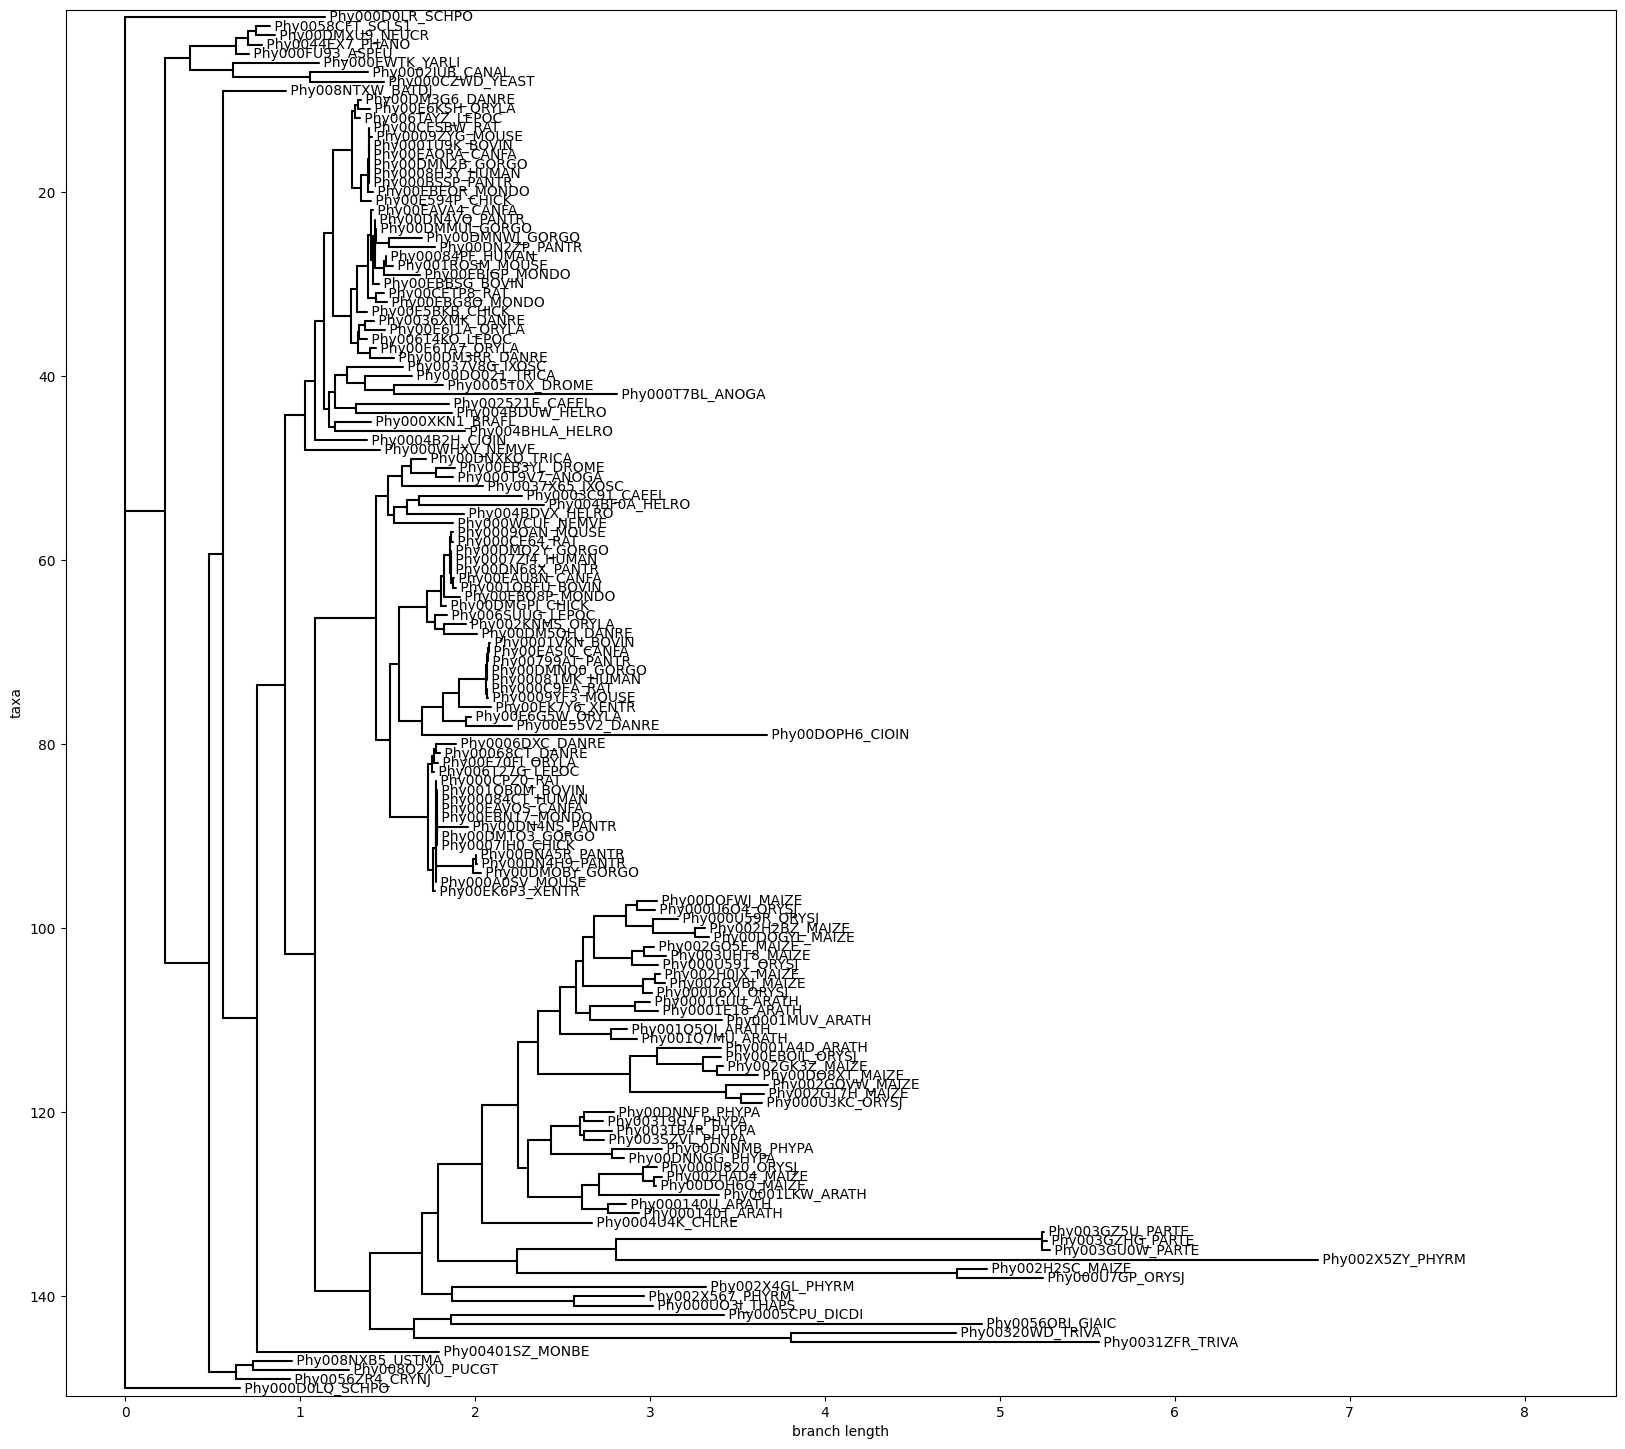

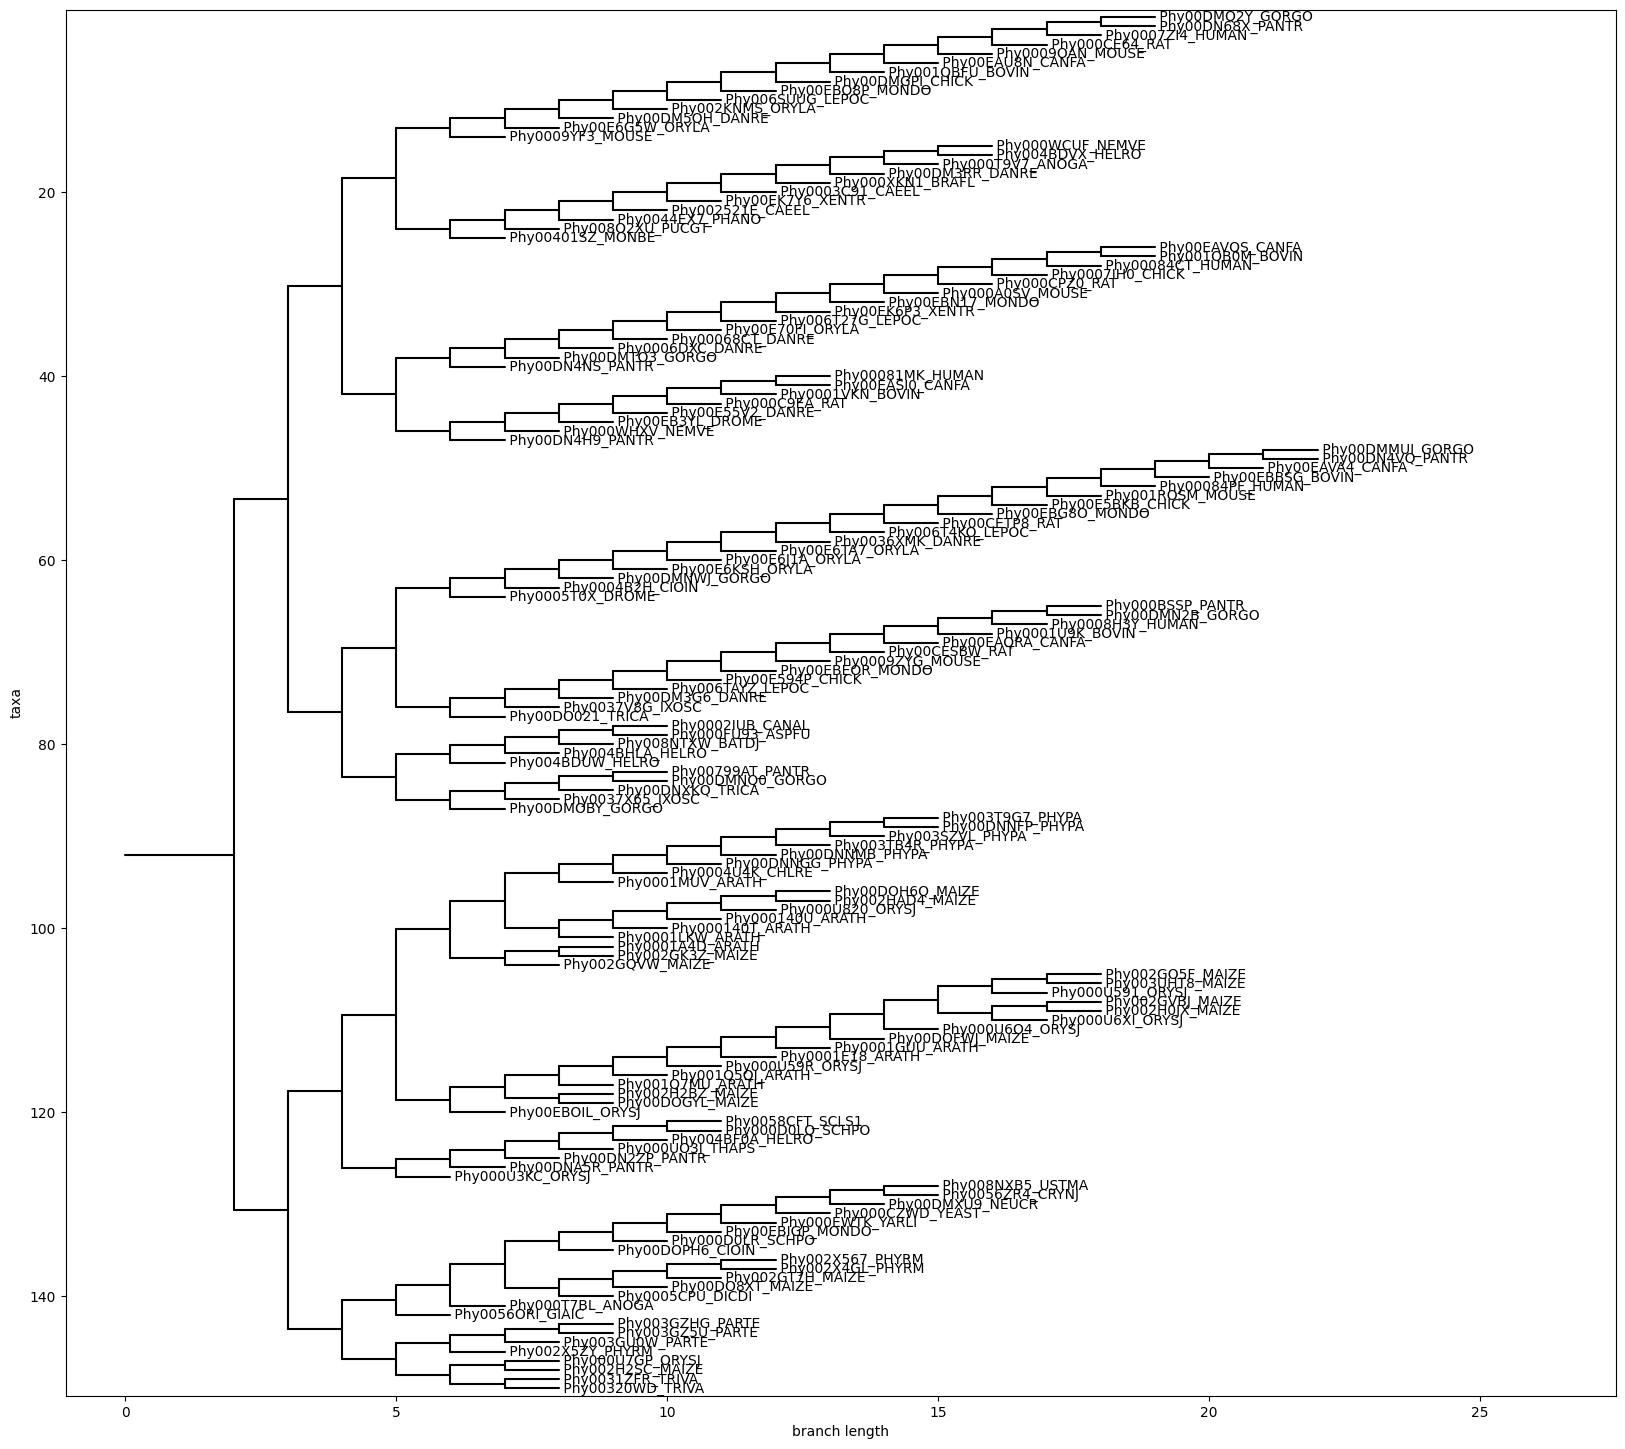

c= 1
min_cut_array= [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
communities 
 ['Phy0002HYG_CANAL', 'Phy0002I1L_CANAL', 'Phy0002INK_CANAL', 'Phy0002J57_CANAL', 'Phy0002JQ0_CANAL', 'Phy0002KIV_CANAL', 'Phy0002KZ2_CANAL', 'Phy0002L42_CANAL', 'Phy0002LBK_CANAL', 'Phy0002LKU_CANAL', 'Phy0002NBY_CANAL', 'Phy0002NDU_CANAL', 'Phy0002NRO_CANAL', 'Phy0002NRP_CANAL', 'Phy0002NW9_CANAL', 'Phy0002O1J_CANAL', 'Phy000AVZ9_NEUCR', 'Phy000AYRG_NEUCR', 'Phy000AZTA_NEUCR', 'Phy000B348_NEUCR', 'Phy000CVR8_YEAST', 'Phy000CVT8_YEAST', 'Phy000CWC0_YEAST', 'Phy000CWF9_YEAST', 'Phy000CWPP_YEAST', 'Phy000CWYV_YE

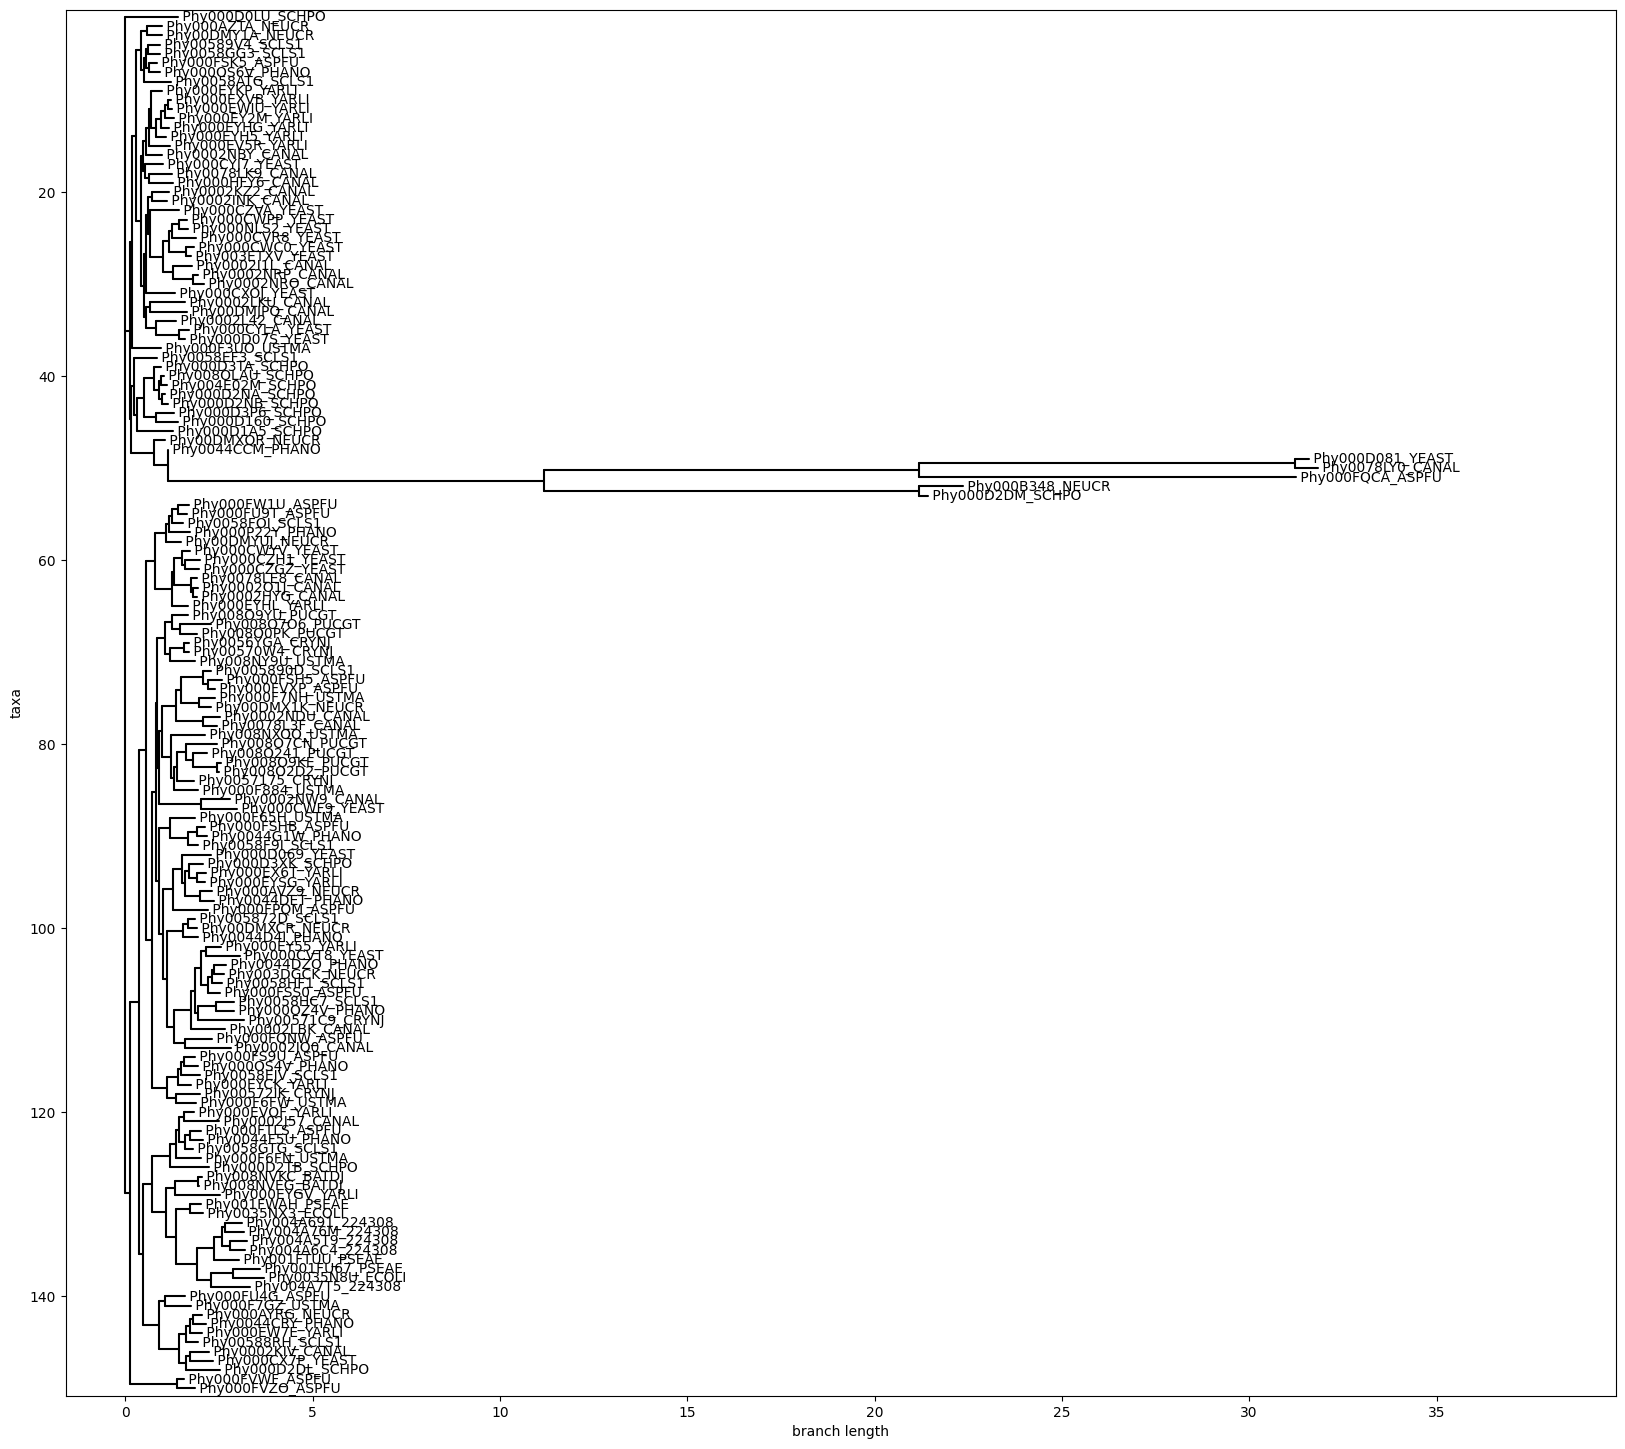

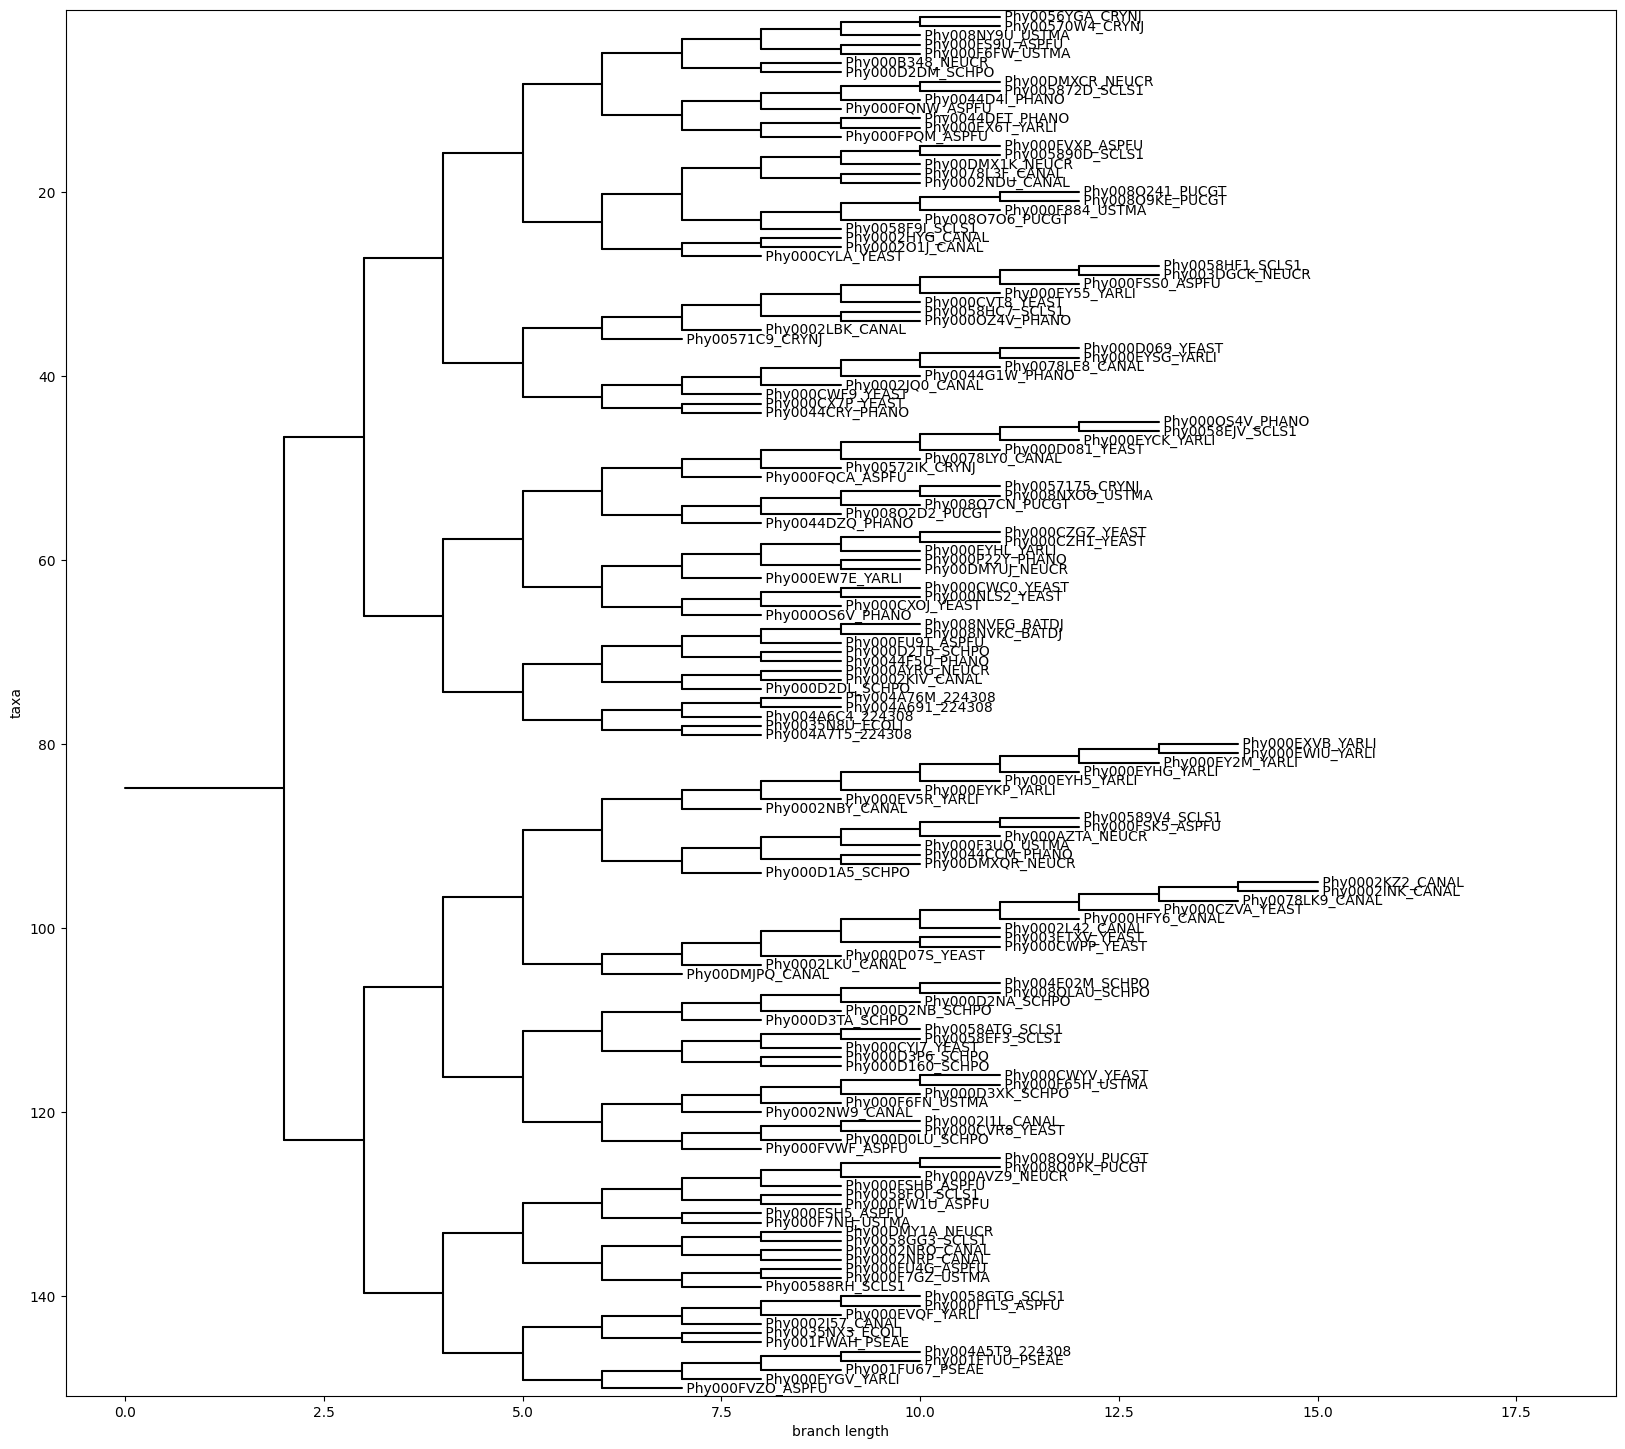

c= 1
min_cut_array= [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
communities 
 ['Phy00000D1_ANOGA', 'Phy00002WM_ANOGA', 'Phy0000BNS_ANOGA', 'Phy000114C_ARATH', 'Phy000114E_ARATH', 'Phy000114I_ARATH', 'Phy0001SPM_BOVIN', 'Phy00025Q9_BOVIN', 'Phy000364X_CAEEL', 'Phy0003B5U_CAEEL', 'Phy0003B5V_CAEEL', 'Phy0003DNT_CAEEL', 'Phy0003N8L_CANFA', 'Phy0004ITB_CIOIN', 'Phy0004UFR_CHLRE', 'Phy0005A8T_DICDI', 'Phy0005ABJ_DICDI', 'Phy0005G6P_DICDI', 'Phy0005HAG_DICDI', 'Phy0005RBZ_DROME', 'Phy0005SIV_DROME', 'Phy0005SR3_DROME', 'Phy0005V9D_DROME', 'Phy0005X5I_DROME', 'Phy0005Z16_DROME', 'Phy0006116_DA

In [ ]:
os.chdir(directory_output)

# import .xslx file with all the real trees

real_tree_lists = import_real_tree(file_real_trees)
data_times = [["Species", "Taxa", "Time"]]

# runs the folder of 'directory' looking for all the possible .tsv files

for file in os.listdir(directory_of_tsv):
    input_file = os.fsdecode(file)
    if input_file.endswith(".tsv"):

        ### RECONSTRUCTED TREE ###

        # applies the sequence of functions to reconstruct the tree
        
        nodes, bitscore_matrix = import_from_tsv(directory_of_tsv+ '\\' + input_file)    # extracts nodes and bitscore matrix
        time_inic = time.time()
        tree_dict = split_nodes(nodes, bitscore_matrix)                                  # splits the nodes with the Digital Annealer
        time_fin = time.time()
        leaves_dict = {k: v for k, v in tree_dict.items() if len(v) == 1}                # gets rid of intermediate nodes (only leaves remain)
        reconstructed_tree = dict_to_newick(leaves_dict, branch_length=1.0)              # turns dictionary into newick format

        # writes reconstructed tree in newick format into output_file

        output_file = input_file.replace(".tsv", "_reconstructed.txt")
        with open(output_file, 'w') as out_file:
            out_file.write(reconstructed_tree)

        ### REAL TREE ###

        # gets real tree with the same name from .xslx file 

        species = input_file.replace(".tsv", "")
        species_list = [sp[0] for sp in real_tree_lists]
        index_tree = species_list.index(species)
        real_tree = prune(real_tree_lists[index_tree][3])                                 # intermediate nodes get pruned out
        
        data_times.append([species, len(nodes), time_fin-time_inic])

        # calculates the percentage of correct branches between the two trees

        percentage = percentage_rf(real_tree, reconstructed_tree, len(nodes))
        print('Species:', species)
        print('Percentage=', percentage, '%')

        # calls function to visualize both trees and saves .jpg image

        visualize(real_tree, species+'_real_graph')
        visualize(reconstructed_tree, species+'_reconstructed_graph')

with open("times_file.txt", "w") as file:
    # Determine column widths for alignment
    col_widths = [max(len(str(row[i])) for row in data_times) for i in range(len(data_times[0]))]

    for row in data_times:
        # Format each row with aligned columns
        formatted_row = "  ".join(f"{str(item):<{col_widths[i]}}" for i, item in enumerate(row))
        file.write(formatted_row + "\n")
        

node_array= ['Phy0000D33_ASHGO', 'Phy0000J6V_APIME', 'Phy0001S5Q_ARATH', 'Phy0001XLQ_BOVIN', 'Phy00026TU_BOVIN', 'Phy0002FYF_BOVIN', 'Phy0002M7M_CANAL', 'Phy00032NW_CAEEL', 'Phy000351T_CAEEL', 'Phy0003S8N_CANFA', 'Phy0003UUW_CANFA', 'Phy00042BO_CANFA', 'Phy00046F3_CANGA', 'Phy00046GH_CANGA', 'Phy0004FE1_CIOIN', 'Phy0004KGU_CIOIN', 'Phy0004O60_CRYNE', 'Phy0004QZL_CRYNE', 'Phy0005BAH_DICDI', 'Phy0005LFJ_DEBHA', 'Phy0005UWE_DROME', 'Phy0005X3Y_DROME', 'Phy000632F_DANRE', 'Phy000632G_DANRE', 'Phy000632L_DANRE', 'Phy0006DFQ_DANRE', 'Phy0006GSM_DANRE', 'Phy0006GZZ_DANRE', 'Phy0006V3O_TAKRU', 'Phy0006VLC_TAKRU', 'Phy0006XG3_TAKRU', 'Phy0006ZFP_TAKRU', 'Phy00076JI_CHICK', 'Phy0007GF5_CHICK', 'Phy0007KUH_CHICK', 'Phy00082FH_HUMAN', 'Phy0008EG5_HUMAN', 'Phy0008LCU_HUMAN', 'Phy0008OF9_KLULA', 'Phy0008QH6_LEIMA', 'Phy000975D_MONDO', 'Phy00097JK_MONDO', 'Phy0009FO6_MONDO', 'Phy0009IRT_MOUSE', 'Phy0009S6G_MOUSE', 'Phy0009X6D_MOUSE', 'Phy000A0P2_MOUSE', 'Phy000AARX_MACMU', 'Phy000ADDS_MACMU', 'Phy000

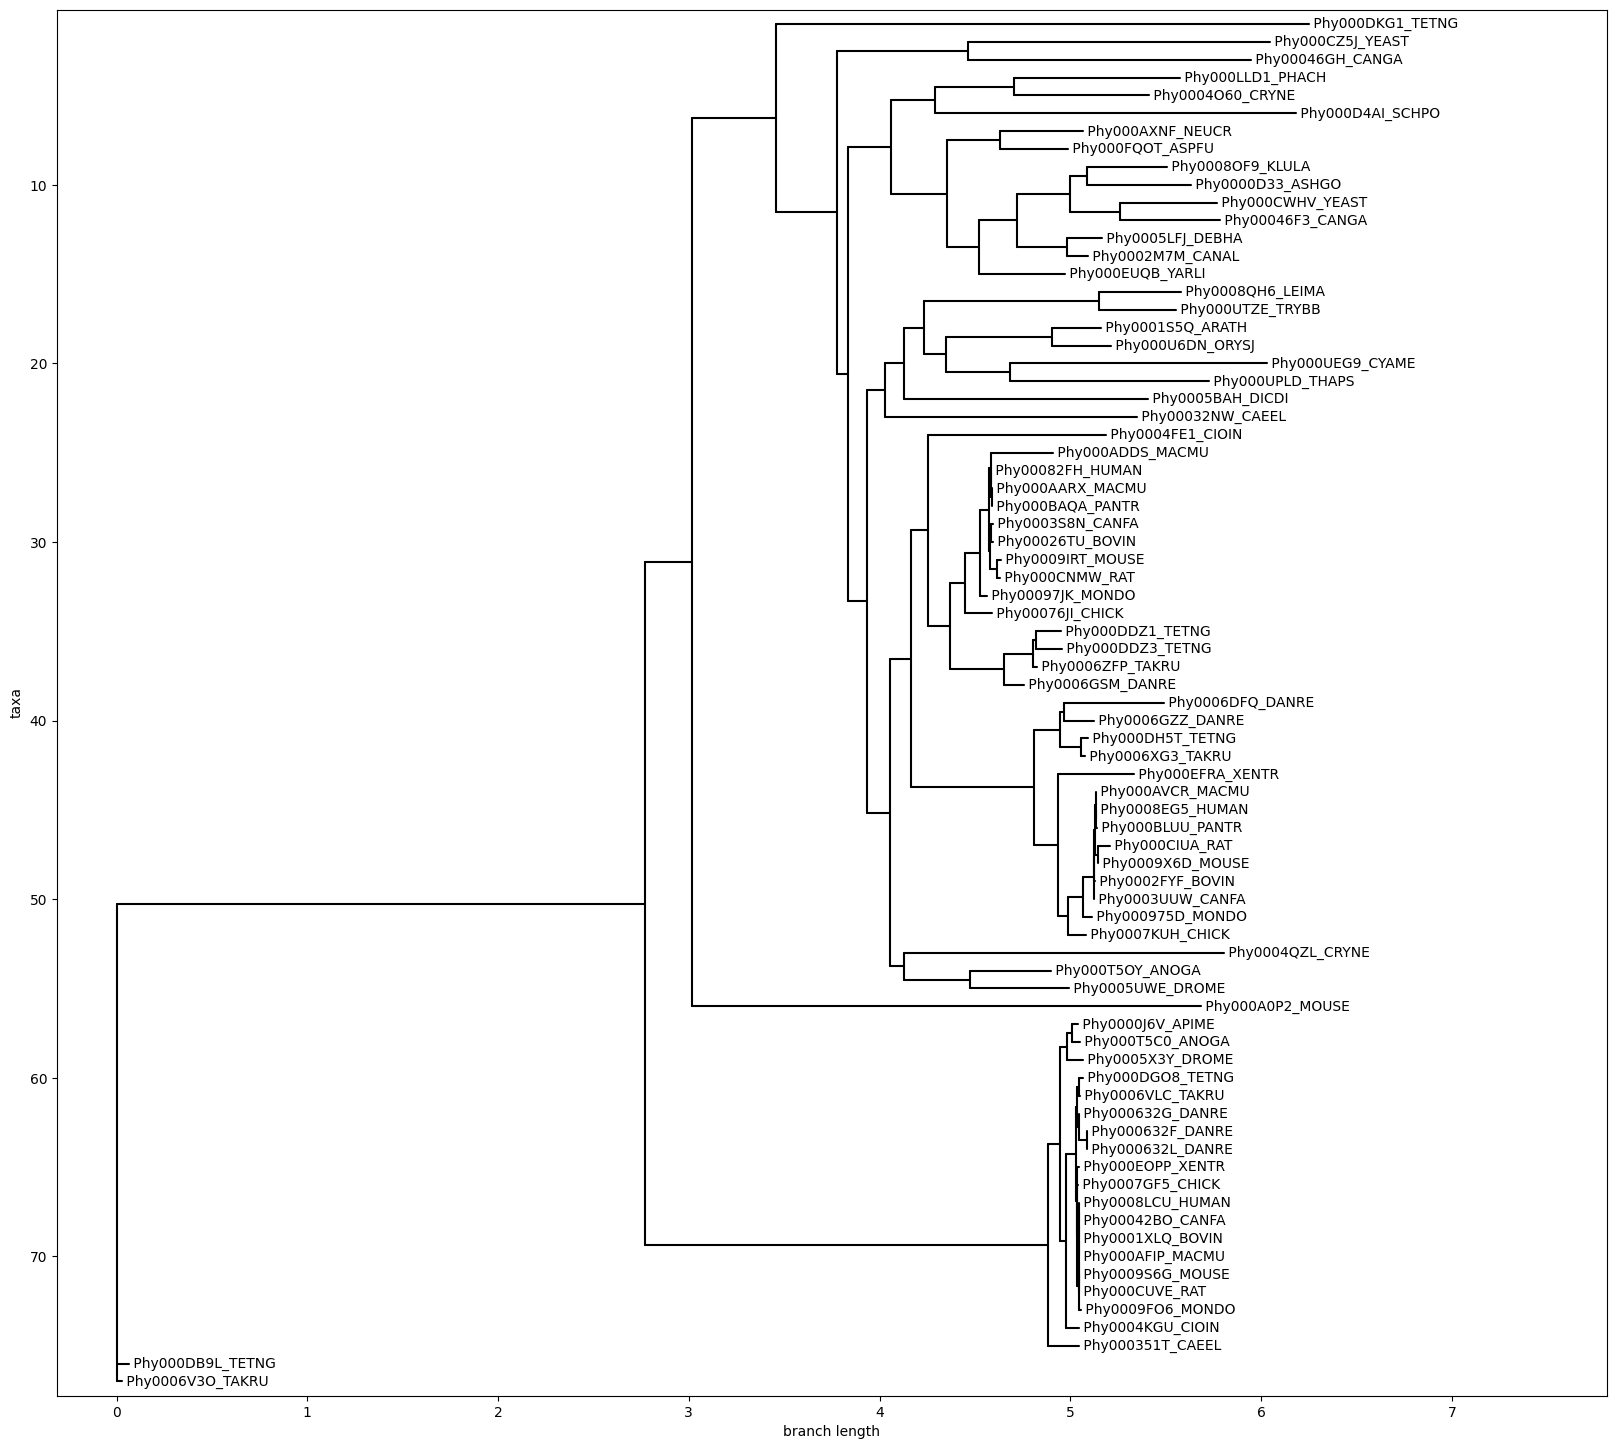

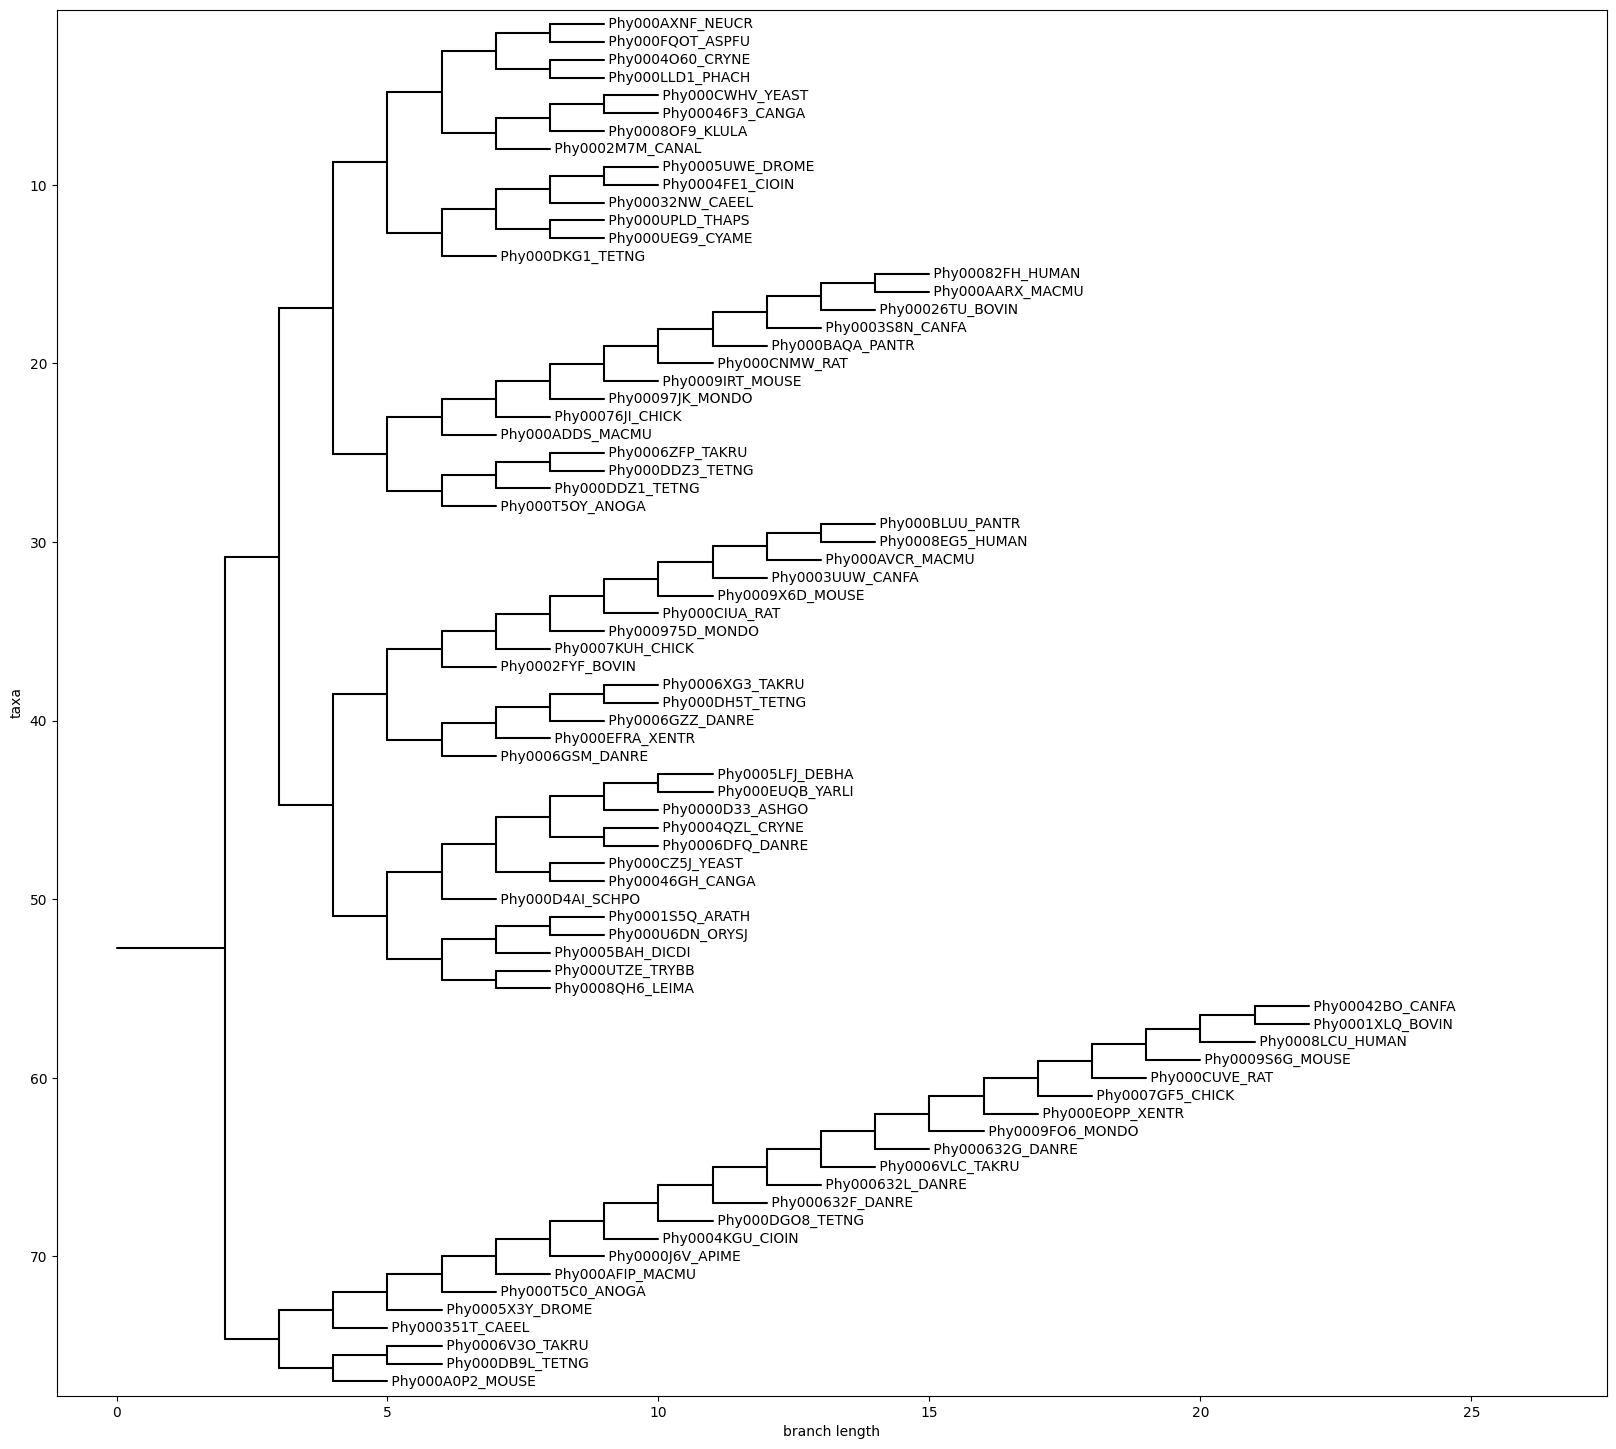

In [46]:
os.chdir(directory_output)

# import .xslx file with all the real trees

real_tree_lists = import_real_tree(file_real_trees)
data_times = [["Species", "Taxa", "Time"]]

# runs the folder of 'directory' looking for all the possible .tsv files

for file in os.listdir(directory_of_tsv):
    input_file = os.fsdecode(file)
    if input_file.endswith(".tsv"):

        ### RECONSTRUCTED TREE ###

        # applies the sequence of functions to reconstruct the tree
        
        nodes, bitscore_matrix = import_from_tsv(directory_of_tsv+ '\\' + input_file)    # extracts nodes and bitscore matrix
        time_inic = time.time()
        tree_dict = split_nodes(nodes, bitscore_matrix)                                  # splits the nodes with the Digital Annealer
        time_fin = time.time()
        leaves_dict = {k: v for k, v in tree_dict.items() if len(v) == 1}                # gets rid of intermediate nodes (only leaves remain)
        reconstructed_tree = dict_to_newick(leaves_dict, branch_length=1.0)              # turns dictionary into newick format

        # writes reconstructed tree in newick format into output_file

        output_file = input_file.replace(".tsv", "_reconstructed.txt")
        with open(output_file, 'w') as out_file:
            out_file.write(reconstructed_tree)

        ### REAL TREE ###

        # gets real tree with the same name from .xslx file 

        species = input_file.replace(".tsv", "")
        species_list = [sp[0] for sp in real_tree_lists]
        index_tree = species_list.index(species)
        real_tree = prune(real_tree_lists[index_tree][3])                                 # intermediate nodes get pruned out
        
        data_times.append([species, len(nodes), time_fin-time_inic])

        # calculates the percentage of correct branches between the two trees

        percentage = percentage_rf(real_tree, reconstructed_tree, len(nodes))
        print('Species:', species)
        print('Percentage=', percentage, '%')

        # calls function to visualize both trees and saves .jpg image

        visualize(real_tree, species+'_real_graph')
        visualize(reconstructed_tree, species+'_reconstructed_graph')

with open("times_file.txt", "w") as file:
    # Determine column widths for alignment
    col_widths = [max(len(str(row[i])) for row in data_times) for i in range(len(data_times[0]))]

    for row in data_times:
        # Format each row with aligned columns
        formatted_row = "  ".join(f"{str(item):<{col_widths[i]}}" for i, item in enumerate(row))
        file.write(formatted_row + "\n")
        

In [ ]:
# FOR MIRANDA

directory_of_tsv = r'<path_to_tsv_files>'

# specify directory of output txt and jpg

directory_output = r'<path_to_output_folder>'

os.chdir(directory_output)

# runs the folder of 'directory' looking for all the possible .tsv files

for file in os.listdir(directory_of_tsv):
    input_file = os.fsdecode(file)
    if input_file.endswith(".tsv"):

        ### RECONSTRUCTED TREE ###

        # applies the sequence of functions to reconstruct the tree
        
        nodes, bitscore_matrix = import_from_tsv(directory_of_tsv+ '\\' + input_file)    # extracts nodes and bitscore matrix

        output_file = input_file.replace(".tsv", "_nodes.txt")
        npi_name = input_file.replace(".tsv",'_matrix')
        
        with open(output_file, 'w') as out_file:
            out_file.write(repr(nodes))
        
        np.save(npi_name, bitscore_matrix)
                

In [ ]:
# NODE LENGTHS

file_real_trees = r'<path_to_excel_file>\file.xlsx'
real_tree_lists = import_real_tree(file_real_trees)

for i in range(500):
    
    real_tree = prune(real_tree_lists[i][3]) 
    handle = StringIO(real_tree)
    tree = Phylo.read(handle, "newick")
    
    leaf_count = sum(1 for clade in tree.find_clades() if clade.is_terminal())

    if leaf_count > 25 and leaf_count < 32:
    
        print(i+1, f"Number of leaf nodes: {leaf_count}")

1 Number of leaf nodes: 29
63 Number of leaf nodes: 28
86 Number of leaf nodes: 27
195 Number of leaf nodes: 26
199 Number of leaf nodes: 31
219 Number of leaf nodes: 28
220 Number of leaf nodes: 30
230 Number of leaf nodes: 27
276 Number of leaf nodes: 26
299 Number of leaf nodes: 30
308 Number of leaf nodes: 29
362 Number of leaf nodes: 31
409 Number of leaf nodes: 31
437 Number of leaf nodes: 27
445 Number of leaf nodes: 28


In [ ]:
directory_of_tree_txt = r'<path_to_tree_txt_files>'
file_real_trees = r'<path_to_excel_file>\file.xlsx'
output_file = r'<path_to_output_folder>\file.txt'

In [ ]:
# CALCULATES DISTANCE METRICS OF RECONSTRUCTED TREES

os.chdir(directory_of_tree_txt)

real_tree_lists = import_real_tree(file_real_trees)
data_matrix = [["Species", "Taxa", "Percentage_RF", "Percentage_Cluster"]]


for file in os.listdir(directory_of_tree_txt):
    input_file = os.fsdecode(file)
    if input_file.endswith("N_reconstructed.txt"):

        with open(input_file, 'r') as file:
            reconstructed_tree = file.read()

        species = input_file.replace("_reconstructed.txt", "")

        species_list = [sp[0] for sp in real_tree_lists]
        index_tree = species_list.index(species)
        real_tree = prune(real_tree_lists[index_tree][3])

        handle_tree = StringIO(real_tree)
        tree_real = Phylo.read(handle_tree, "newick")
        len_nodes = len(tree_real.get_terminals())

        perc_rf = percentage_rf(real_tree, reconstructed_tree, len_nodes)        
        perc_cd = percentage_cd(real_tree, reconstructed_tree)

        data_matrix.append([species, len_nodes, perc_rf, perc_cd])

with open(output_file, "w") as file:
    # Determine column widths for alignment
    col_widths = [max(len(str(row[i])) for row in data_matrix) for i in range(len(data_matrix[0]))]

    for row in data_matrix:
        # Format each row with aligned columns
        formatted_row = "  ".join(f"{str(item):<{col_widths[i]}}" for i, item in enumerate(row))
        file.write(formatted_row + "\n")